# Overview
### Objective

Perform analysis that shows synthetic lethality dependence of STAG2 and STAG1. Briefly describe steps of your analysis and provide code and input data to reproduce your results.

### Comprehensive prediction of robust synthetic lethality between paralog pairs in cancer cell lines

by analyzing genome-wide CRISPR screens and molecular profiles of over 700 cancer cell lines, autors identify features predictive of synthetic lethality between paralogs, including shared protein-protein interactions and evolutionary conservation. Also they develop a machine-learning classifier based on these features to predict which paralog pairs are most likely to be synthetic lethal and to explain why. 


[GitHab paralog_SL_prediction](https://github.com/cancergenetics/paralog_SL_prediction)

[Full text paper](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(21)00329-X)


Taking into consideration that authors already generated results on 700 cancer cell line I see no point to rerun the analysis becouse of several reasons:

1.) To reproduce the analysis I need to refactor the code to parallelize it, make a workflow DSL wrapper, prepare images and run it on AWS Batch. It will take time.

2.) Novelity - it make a sense having bigger custom input dataset, otherwise we can simply download summary of the results

3.) Our task is to computationally proove SL between STAG1 and STAG2, autors already present the results for this couple of genes

Instead we simply make some small EDA and highlight the results, intresting for us

In [103]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 2.6 MB/s eta 0:00:00a 0:00:01


In [210]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_theme(style="whitegrid")

In [206]:
zmin=-2; zmax=2
def calculate_zscores_for_feature(x):
    dtype = df_sharp[x.name].dtype
    if dtype == 'float64' or dtype=="int64":
        return pd.Series(stats.zscore(np.array(x.values, dtype=np.float64))).clip(lower=zmin, upper=zmax)
    elif dtype == 'bool':
        return x.apply(lambda y: 2 if y==True else -2)
    else:
        print('Unexpected type:', dtype)
        
def draw_colorbar(f, ax, cmap, zmin, zmax, height=0.5, width=0.015, xpadding=0.03, ypadding=0):
    bbox_ax = ax.get_position()
    # colorbar is bounded by [x0, y0, x_width, y_width]
    cbar_ax = f.add_axes([bbox_ax.x1+xpadding, bbox_ax.y0+ypadding, width, (bbox_ax.y1-bbox_ax.y0)*height])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(zmin, zmax))
    cbar = f.colorbar(sm, cax=cbar_ax, ticks=[-1.2, -0.4, 0.4, 1.2])
    cbar.set_label('Feature z-score', rotation=270, labelpad=10)
    cbar.outline.set_visible(False)
    cbar_ax.tick_params(right=False, pad=0)
    for t in cbar_ax.get_yticklabels(): t.set_fontsize(8)
    return cbar_ax

def draw_shap_plot_for_pair(A1, A2, ax, feature_order=[], n=10):
    pair = pd.DataFrame({'A1':A1, 'A2':A2}, index=[0])
    # DF incl. columns: feature, shap_value, zcore
    df = pd.merge(pair, all_shap_and_zscore)
    # Order features
    if len(feature_order)==0:
        df = df[df.index.isin(df.shap_value.abs().nlargest(n=n).index)].sort_values('shap_value', ascending=False)
    else:
        df = df.set_index('feature').loc[feature_order,:].reset_index()
    # Map zscore to a discrete color range
    df['color_idx'] = df.zscore.apply(lambda x: np.round(((x-zmin)/(zmax-zmin)) * (len(palette)-1)).astype(np.int32))
    sns.barplot(x=df.shap_value, y=df.simple_name, ax=ax, palette=np.array(palette)[df.color_idx.values], saturation=1)
    ax.tick_params(axis='y', which='both', length=0); ax.set_ylabel('')
    ax.set_title(A1+'/'+A2, fontsize=9, fontweight='bold', fontstyle="italic")
    ax.set_xlabel('SHAP value')


### Results overview
General table with all results for all pairs

In [4]:
df_results = pd.read_csv("http://www.cancergd.org/static/paralogs/supp_tables/Table_S8.csv")
print(df_results.shape)
df_results.head(5)

(36648, 36)


prediction_rank  prediction_percentile sorted_gene_pair       A1       A2  \
0                1                    0.1  SMARCA2_SMARCA4  SMARCA2  SMARCA4   
1                2                    0.1     EXOC6_EXOC6B    EXOC6   EXOC6B   
2                3                    0.1      STAG1_STAG2    STAG1    STAG2   
3                4                    0.1       RPL3_RPL3L     RPL3    RPL3L   
4                5                    0.1      CNOT7_CNOT8    CNOT7    CNOT8   

   A1_entrez  A2_entrez       A1_ensembl       A2_ensembl  prediction_score  \
0       6595       6597  ENSG00000080503  ENSG00000127616          0.430886   
1      54536      23233  ENSG00000138190  ENSG00000144036          0.410447   
2      10274      10735  ENSG00000118007  ENSG00000101972          0.405952   
3       6122       6123  ENSG00000100316  ENSG00000140986          0.402074   
4      29883       9337  ENSG00000198791  ENSG00000155508          0.399963   

   ...  either_in_complex  mean_complex_essentiality  colocalisation interact  \
0  ...               True                   0.387262        0.333333     True   
1  ...               True                   0.486857        0.250000     True   
2  ...               True                   0.897254        0.000000    False   
3  ...               True                   0.853090        0.000000    False   
4  ...               True                   0.369246        0.000000    False   

   n_total_ppi  fet_ppi_overlap  shared_ppi_mean_essentiality  \
0          302       114.614142                      0.225382   
1           53        29.782706                      0.285886   
2           74        39.412527                      0.329993   
3          269        55.904504                      0.897190   
4           82        56.161358                      0.154692   

   gtex_spearman_corr  gtex_min_mean_expr  gtex_max_mean_expr  
0            0.627875           18.609973           34.302868  
1            0.069456            6.390812           11.168367  
2            0.854086           13.103716           22.097616  
3           -0.120226           16.459348         1418.958855  
4            0.482402           14.829783           41.019617  

[5 rows x 36 columns]

In [43]:
df_results.describe()

prediction_rank  prediction_percentile     A1_entrez     A2_entrez  \
count     36648.000000           36648.000000  3.664800e+04  3.664800e+04   
mean      18324.500000              50.051353  1.964516e+06  2.317176e+06   
std       10579.510669              28.867891  1.363661e+07  1.479568e+07   
min           1.000000               0.100000  1.000000e+00  1.000000e+01   
25%        9162.750000              25.075000  4.185000e+03  6.493750e+03   
50%       18324.500000              50.050000  1.075100e+04  5.130750e+04   
75%       27486.250000              75.025000  9.082700e+04  1.481770e+05   
max       36648.000000             100.000000  1.160340e+08  1.160340e+08   

       prediction_score     n_screens  n_screens_SL  min_sequence_identity  \
count      36648.000000  36648.000000  36648.000000           36648.000000   
mean           0.027773      0.069663      0.007886               0.369284   
std            0.032244      0.336967      0.111147               0.218278   
min            0.009641      0.000000      0.000000               0.010748   
25%            0.013098      0.000000      0.000000               0.208307   
50%            0.020153      0.000000      0.000000               0.315681   
75%            0.028310      0.000000      0.000000               0.475511   
max            0.430886      4.000000      4.000000               1.000000   

        family_size  cds_length_ratio  ...  conservation_score      mean_age  \
count  36648.000000      36648.000000  ...        36648.000000  36648.000000   
mean      12.707460          0.819403  ...            4.812404    591.642738   
std        9.606582          0.193855  ...            2.093297    516.477646   
min        2.000000          0.030604  ...            0.000000      0.000000   
25%        6.000000          0.733022  ...            4.000000    250.300000   
50%       11.000000          0.892273  ...            5.000000    486.550000   
75%       15.000000          0.967648  ...            6.000000    859.500000   
max       48.000000          1.000000  ...            9.000000   4200.000000   

       mean_complex_essentiality  colocalisation   n_total_ppi  \
count               36648.000000    36648.000000  36648.000000   
mean                    0.043248        0.111693     67.493942   
std                     0.142267        0.259848    135.725490   
min                     0.000000        0.000000      0.000000   
25%                     0.000000        0.000000      8.000000   
50%                     0.000000        0.000000     29.000000   
75%                     0.000000        0.000000     75.000000   
max                     1.000000        1.000000   3030.000000   

       fet_ppi_overlap  shared_ppi_mean_essentiality  gtex_spearman_corr  \
count     36648.000000                  36648.000000        36648.000000   
mean          5.236874                      0.083114            0.302273   
std          17.163701                      0.188636            0.259783   
min          -0.205010                      0.000000           -0.596479   
25%           0.000000                      0.000000            0.106701   
50%           0.000000                      0.000000            0.283863   
75%           3.363894                      0.044320            0.494694   
max         323.306215                      1.000000            0.989557   

       gtex_min_mean_expr  gtex_max_mean_expr  
count        36648.000000        36648.000000  
mean             9.267411           48.228469  
std             42.608006          263.656025  
min              0.000000            0.000000  
25%              0.332784            3.209119  
50%              2.306785           11.657316  
75%              7.879306           32.372743  
max           4024.198166        12927.514623  

[8 rows x 21 columns]

### All STAG genes
Let's check our's genes of interest, for comparison let's have a look at all STAG genes

In [64]:
df_results[(df_results["A1"] == "STAG1") | (df_results["A1"] == "STAG2")].T

2                1321  \
prediction_rank                                  3             1322   
prediction_percentile                          0.1              3.7   
sorted_gene_pair                       STAG1_STAG2      STAG1_STAG3   
A1                                           STAG1            STAG1   
A2                                           STAG2            STAG3   
A1_entrez                                    10274            10274   
A2_entrez                                    10735            10734   
A1_ensembl                         ENSG00000118007  ENSG00000118007   
A2_ensembl                         ENSG00000101972  ENSG00000066923   
prediction_score                          0.405952         0.087899   
validated_SL                                  True            False   
n_screens                                        1                0   
n_screens_SL                                     1                0   
depmap_hit                                    True              NaN   
min_sequence_identity                     0.708202         0.472178   
closest                                       True            False   
WGD                                           True             True   
family_size                                      3                3   
cds_length_ratio                           0.99212         0.974583   
shared_domains                                 1.0              1.0   
has_pombe_ortholog                            True             True   
has_essential_pombe_ortholog                  True             True   
has_cerevisiae_ortholog                       True             True   
has_essential_cerevisiae_ortholog             True             True   
conservation_score                               8                8   
mean_age                                    1368.0           1368.0   
either_in_complex                             True             True   
mean_complex_essentiality                 0.897254         0.821169   
colocalisation                                 0.0              0.0   
interact                                     False            False   
n_total_ppi                                     74               35   
fet_ppi_overlap                          39.412527         5.458397   
shared_ppi_mean_essentiality              0.329993         0.997399   
gtex_spearman_corr                        0.854086         0.228924   
gtex_min_mean_expr                       13.103716         5.075085   
gtex_max_mean_expr                       22.097616        13.103716   

                                              1477  
prediction_rank                               1478  
prediction_percentile                          4.1  
sorted_gene_pair                       STAG2_STAG3  
A1                                           STAG2  
A2                                           STAG3  
A1_entrez                                    10735  
A2_entrez                                    10734  
A1_ensembl                         ENSG00000101972  
A2_ensembl                         ENSG00000066923  
prediction_score                          0.081454  
validated_SL                                 False  
n_screens                                        0  
n_screens_SL                                     0  
depmap_hit                                     NaN  
min_sequence_identity                     0.474763  
closest                                      False  
WGD                                           True  
family_size                                      3  
cds_length_ratio                          0.966903  
shared_domains                                 1.0  
has_pombe_ortholog                            True  
has_essential_pombe_ortholog                  True  
has_cerevisiae_ortholog                       True  
has_essential_cerevisiae_ortholog             True  
conservation_score                               8  
mean_age                                

### STAG1/STAG2
In total 3 pairs are presented in the final results, we are intreseted in the pair STAG1 and STAG2

In [25]:
mask = (df_results["sorted_gene_pair"] == "STAG1_STAG2")
df_results[mask].T

2
prediction_rank                                  3
prediction_percentile                          0.1
sorted_gene_pair                       STAG1_STAG2
A1                                           STAG1
A2                                           STAG2
A1_entrez                                    10274
A2_entrez                                    10735
A1_ensembl                         ENSG00000118007
A2_ensembl                         ENSG00000101972
prediction_score                          0.405952
validated_SL                                  True
n_screens                                        1
n_screens_SL                                     1
depmap_hit                                    True
min_sequence_identity                     0.708202
closest                                       True
WGD                                           True
family_size                                      3
cds_length_ratio                           0.99212
shared_domains                                 1.0
has_pombe_ortholog                            True
has_essential_pombe_ortholog                  True
has_cerevisiae_ortholog                       True
has_essential_cerevisiae_ortholog             True
conservation_score                               8
mean_age                                    1368.0
either_in_complex                             True
mean_complex_essentiality                 0.897254
colocalisation                                 0.0
interact                                     False
n_total_ppi                                     74
fet_ppi_overlap                          39.412527
shared_ppi_mean_essentiality              0.329993
gtex_spearman_corr                        0.854086
gtex_min_mean_expr                       13.103716
gtex_max_mean_expr                       22.097616

What's important here is that the pair STAG1 vs STAG2 located in the top list of prediction, ranked third most probable out of ~37.000 pairs

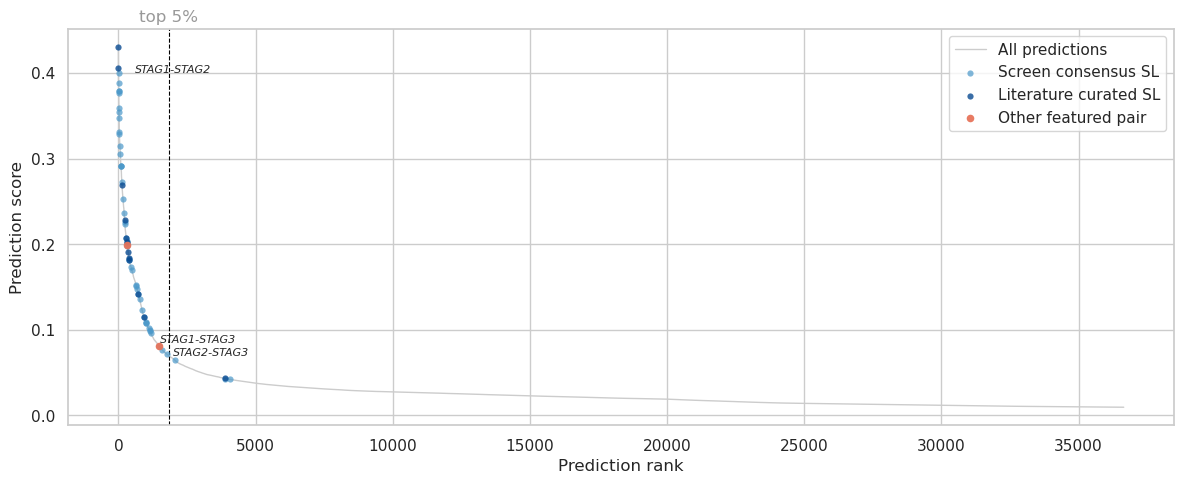

In [74]:
f, ax = plt.subplots(1, 1, figsize=(12,5))
pal = sns.color_palette("Blues", n_colors=9)
df = df_results

sns.lineplot(x=df.index, y=df.prediction_score, ax=ax, alpha=1, color='#ccc', label="All predictions", zorder=1, lw=1)

sns.scatterplot(x=df[df.n_screens_SL>=2].index, y=df[df.n_screens_SL>=2].prediction_score, ax=ax, linewidth=0, s=20, alpha=0.7,
                color=pal[5], label="Screen consensus SL", zorder=2)

sns.scatterplot(x=df[df.validated_SL].index, y=df[df.validated_SL].prediction_score, ax=ax, linewidth=0, s=20, alpha=0.8,
                color=pal[8], label="Literature curated SL", zorder=3)

example_df = df_results[(df_results.A1=='STAG2') | ((df_results.A1=='AKT1') & (df_results.A2=='AKT2'))]
sns.scatterplot(x=example_df.index, y=example_df.prediction_score, ax=ax, linewidth=0, s=30, alpha=0.95,
                color='#e7745b', label="Other featured pair", zorder=4)

ax.set_ylabel('Prediction score'); ax.set_xlabel('Prediction rank')

# Draw line to show top 5%
ax.axvline(int(0.05*df.shape[0]), linestyle='--', color='black', zorder=1, lw=0.8)
ax.text(int(0.05*df.shape[0]), 0.46, 'top 5%', fontsize=12, color='#999', ha='center')
plt.tight_layout()

# Paralog pair annotations: pair:[text_coords, line_start_coords, line_end_coords]
annots = {'STAG1-STAG2':[(600, 0.40), (400, 0.42), (1000, 0.401)],
          'STAG2-STAG3': [(2000, 0.07), (1000, 0.085), (3100, 0.095)],
         'STAG1-STAG3': [(1500, 0.085), (1000, 0.085), (3100, 0.095)]}
for key, val in annots.items():
    ax.text(val[0][0], val[0][1], key, fontsize=8, fontstyle="italic")

As we can see pair STAG1 - STAG2 is in the top of predictions

In [44]:
df_results[(df_results["A1"] == "STAG1") | (df_results["A1"] == "STAG2")]

prediction_rank  prediction_percentile sorted_gene_pair     A1     A2  \
2                   3                    0.1      STAG1_STAG2  STAG1  STAG2   
1321             1322                    3.7      STAG1_STAG3  STAG1  STAG3   
1477             1478                    4.1      STAG2_STAG3  STAG2  STAG3   

      A1_entrez  A2_entrez       A1_ensembl       A2_ensembl  \
2         10274      10735  ENSG00000118007  ENSG00000101972   
1321      10274      10734  ENSG00000118007  ENSG00000066923   
1477      10735      10734  ENSG00000101972  ENSG00000066923   

      prediction_score  ...  either_in_complex  mean_complex_essentiality  \
2             0.405952  ...               True                   0.897254   
1321          0.087899  ...               True                   0.821169   
1477          0.081454  ...               True                   0.816520   

      colocalisation interact  n_total_ppi  fet_ppi_overlap  \
2                0.0    False           74        39.412527   
1321             0.0    False           35         5.458397   
1477             0.0    False           58         5.014641   

      shared_ppi_mean_essentiality  gtex_spearman_corr  gtex_min_mean_expr  \
2                         0.329993            0.854086           13.103716   
1321                      0.997399            0.228924            5.075085   
1477                      0.997399            0.317754            5.075085   

      gtex_max_mean_expr  
2              22.097616  
1321           13.103716  
1477           22.097616  

[3 rows x 36 columns]

### Used Features

In [122]:
df_features = pd.read_excel("http://www.cancergd.org/static/paralogs/supp_tables/Table_S6.xlsx")
print(df_features.shape)
df_features = df_features.iloc[:,:5]
cols = ["simple_name","feature","category","description","source"]
df_features.set_axis(cols, axis=1,inplace=True)
df_features.head(25)

(22, 9)


simple_name                            feature  \
0                    Sequence Identity              min_sequence_identity   
1                      Closest Paralog                            closest   
2                          Family Size                        family_size   
3                    Gene Length Ratio                   cds_length_ratio   
4              Whole Genome Duplicates                                WGD   
5                    S. pombe Ortholog                 has_pombe_ortholog   
6          Essential S. pombe Ortholog       has_essential_pombe_ortholog   
7               S. cerevisiae Ortholog            has_cerevisiae_ortholog   
8     Essential S. cerevisiae Ortholog  has_essential_cerevisiae_ortholog   
9                   Conservation Score                 conservation_score   
10                                 Age                           mean_age   
11                      Shared Domains                     shared_domains   
12  Shared Protein-Protein Interactors                    fet_ppi_overlap   
13         Protein-Protein Interaction                           interact   
14   Total Protein-Protein Interactors                        n_total_ppi   
15         Essentiality of Shared PPIs       shared_ppi_mean_essentiality   
16          Protein Complex Membership                  either_in_complex   
17     Essentiality of Protein Complex          mean_complex_essentiality   
18                      Colocalisation                     colocalisation   
19              Expression Correlation                 gtex_spearman_corr   
20             Mean Expression (Lower)                 gtex_min_mean_expr   
21            Mean Expression (Higher)                 gtex_max_mean_expr   

        category                                        description  \
0       Sequence  The minimum of: the percent of A1's protein-co...   
1       Sequence  Whether A1 and A2 are each other's closest par...   
2       Sequence  The number of paralogs in the family that incl...   
3       Sequence  The ratio of the lengths of A1 and A2's coding...   
4       Sequence  Whether A1 and A2 originate from a whole genom...   
5       Sequence  Whether A1 and/or A2 have an ortholog in S. po...   
6       Sequence  Whether A1 and/or A2 have an essential ortholo...   
7       Sequence  Whether A1 and/or A2 have an ortholog in S. ce...   
8       Sequence  Whether A1 and/or A2 have an essential ortholo...   
9       Sequence  Number of species, out of nine, in which A1 an...   
10      Sequence                         The mean age of A1 and A2.   
11      Sequence  The Jaccard index (intersection over union) of...   
12  Neighborhood  The -log10 p-value from the Fisher's exact tes...   
13  Neighborhood  Whether there is evidence of a protein-protein...   
14  Neighborhood  Union of all of A1 and A2's protein-protein in...   
15  Neighborhood  The mean essentiality of A1 and A2's shared pr...   
16  Neighborhood  Whether A1 and/or A2 are members of at least 1...   
17  Neighborhood  The mean essentiality of the complexes in whic...   
18  Neighborhood  The Jaccard index (intersection over union) of...   
19    Expression  The Spearman correlation coefficient of A1 and...   
20    Expression  The average expression of the lowest expressed...   
21    Expression  The average expression of the highest expresse...   

                               source  
0                             Ensembl  
1                             Ensembl  
2                             Ensembl  
3                             Ensembl  
4   Makino and McLysaght, OHNOLOGS v2  
5                             PomBase  
6                           Kim et al  
7                             Ensembl  
8                                OGEE  
9                 Ensembl, InParanoid  
10                   ProteinHistorian  
11                            Ensembl  
12                            BioGRID  
13                            BioGRID  
14                   

### Feature importance
Next we want to see Feature description, Feature importance in general and for our pairs in more detailed way.
To do so we will check the SHARP values across pairs and features

In [197]:
df_sharp = pd.read_csv("http://www.cancergd.org/static/paralogs/supp_tables/Table_S9.csv", sep=",")
df_sharp

prediction_rank sorted_gene_pair       A1       A2  A1_entrez  \
0                    1  SMARCA2_SMARCA4  SMARCA2  SMARCA4       6595   
1                    2     EXOC6_EXOC6B    EXOC6   EXOC6B      54536   
2                    3      STAG1_STAG2    STAG1    STAG2      10274   
3                    4       RPL3_RPL3L     RPL3    RPL3L       6122   
4                    5      CNOT7_CNOT8    CNOT7    CNOT8      29883   
...                ...              ...      ...      ...        ...   
36643            36644     ZNF141_ZNF93   ZNF141    ZNF93       7700   
36644            36645      ZIK1_ZNF211     ZIK1   ZNF211     284307   
36645            36646    ZNF441_ZNF791   ZNF441   ZNF791     126068   
36646            36647    ZNF117_ZNF493   ZNF117   ZNF493      51351   
36647            36648    ZNF525_ZNF600   ZNF525   ZNF600     170958   

       A2_entrez  prediction_score  min_sequence_identity   closest       WGD  \
0           6597          0.430886               0.161258  0.024044  0.007880   
1          23233          0.410447               0.161088  0.023801  0.005154   
2          10735          0.405952               0.169284  0.023557  0.005115   
3           6123          0.402074               0.145928  0.022755  0.005666   
4           9337          0.399963               0.149085  0.022328  0.004631   
...          ...               ...                    ...       ...       ...   
36643      81931          0.009641              -0.003704 -0.003043 -0.001063   
36644      10520          0.009641              -0.003604 -0.003032 -0.001022   
36645     163049          0.009641              -0.003713 -0.003006 -0.001023   
36646     284443          0.009641              -0.003708 -0.003029 -0.001018   
36647     162966          0.009641              -0.003604 -0.003052 -0.001067   

       ...  either_in_complex  mean_complex_essentiality  colocalisation  \
0      ...           0.001976                   0.054886        0.000172   
1      ...           0.002148                   0.062069        0.000453   
2      ...           0.002045                   0.070572       -0.000582   
3      ...           0.002075                   0.056230       -0.000825   
4      ...           0.002167                   0.067702       -0.000996   
...    ...                ...                        ...             ...   
36643  ...          -0.000180                  -0.004566       -0.000071   
36644  ...          -0.000180                  -0.004563       -0.000071   
36645  ...          -0.000180                  -0.004442       -0.000071   
36646  ...          -0.000180                  -0.004450       -0.000071   
36647  ...          -0.000180                  -0.004565       -0.000071   

       interact  n_total_ppi  fet_ppi_overlap  shared_ppi_mean_essentiality  \
0      0.001757     0.001503         0.049722                      0.004440   
1      0.001687     0.002408         0.012050                      0.002372   
2     -0.000994     0.002349         0.012984                      0.002553   
3     -0.001113    -0.001557         0.027137                      0.002490   
4     -0.001213     0.004775         0.034546                      0.002499   
...         ...          ...              ...                           ...   
36643 -0.000174     0.000031        -0.004229                     -0.000637   
36644 -0.000172     0.000017        -0.004327                     -0.000637   
36645 -0.000172     0.000031        -0.004269                     -0.000637   
36646 -0.000174     0.000022        -0.004259                     -0.000637   
36647 -0.000190     0.000022        -0.004315                     -0.000637   

       gtex_spearman_corr  gtex_min_mean_expr  gtex_max_mean_expr  
0               -0.000868            0.002244            0.000671  
1                0.003945           -0.001956            0.000252  
2                0.000213            0.001005            0.000016  
3                0.005930          

In [198]:
features_lables = df_features[["simple_name","feature","category"]]
features_lables

simple_name                            feature  \
0                    Sequence Identity              min_sequence_identity   
1                      Closest Paralog                            closest   
2                          Family Size                        family_size   
3                    Gene Length Ratio                   cds_length_ratio   
4              Whole Genome Duplicates                                WGD   
5                    S. pombe Ortholog                 has_pombe_ortholog   
6          Essential S. pombe Ortholog       has_essential_pombe_ortholog   
7               S. cerevisiae Ortholog            has_cerevisiae_ortholog   
8     Essential S. cerevisiae Ortholog  has_essential_cerevisiae_ortholog   
9                   Conservation Score                 conservation_score   
10                                 Age                           mean_age   
11                      Shared Domains                     shared_domains   
12  Shared Protein-Protein Interactors                    fet_ppi_overlap   
13         Protein-Protein Interaction                           interact   
14   Total Protein-Protein Interactors                        n_total_ppi   
15         Essentiality of Shared PPIs       shared_ppi_mean_essentiality   
16          Protein Complex Membership                  either_in_complex   
17     Essentiality of Protein Complex          mean_complex_essentiality   
18                      Colocalisation                     colocalisation   
19              Expression Correlation                 gtex_spearman_corr   
20             Mean Expression (Lower)                 gtex_min_mean_expr   
21            Mean Expression (Higher)                 gtex_max_mean_expr   

        category  
0       Sequence  
1       Sequence  
2       Sequence  
3       Sequence  
4       Sequence  
5       Sequence  
6       Sequence  
7       Sequence  
8       Sequence  
9       Sequence  
10      Sequence  
11      Sequence  
12  Neighborhood  
13  Neighborhood  
14  Neighborhood  
15  Neighborhood  
16  Neighborhood  
17  Neighborhood  
18  Neighborhood  
19    Expression  
20    Expression  
21    Expression

### TOP 10 most important features

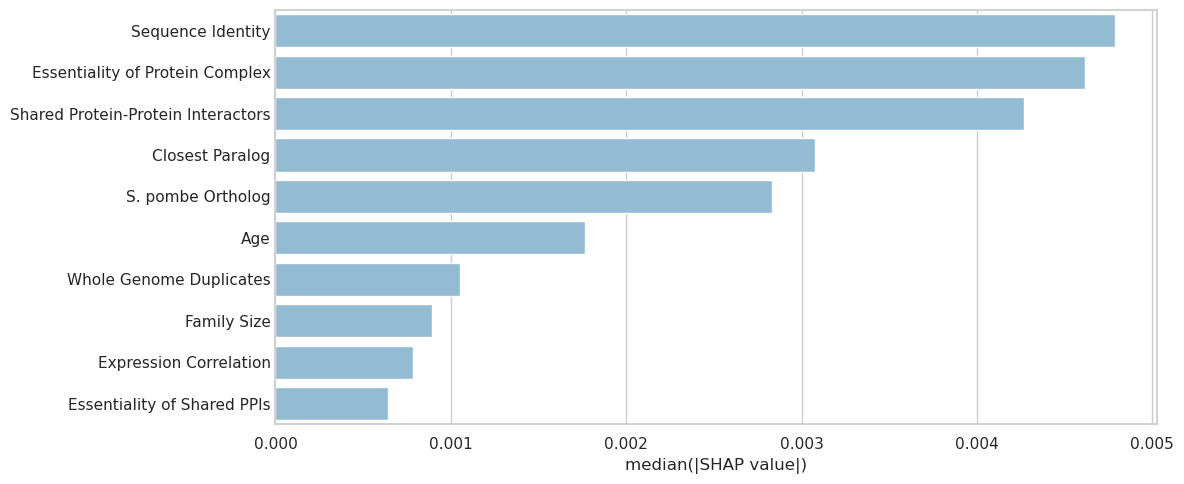

In [199]:
med_abs_shap = df_sharp.iloc[:,5:].abs().median().sort_values(ascending=False).reset_index()
med_abs_shap.columns = ['feature','value']
med_abs_shap = pd.merge(med_abs_shap, features_lables, on="feature")
top_features = med_abs_shap.feature.values.tolist()
f, ax = plt.subplots(1, 1, figsize=(12,5))
sns.barplot(y=med_abs_shap[:10]['simple_name'], x=med_abs_shap[:10]['value'], color=sns.color_palette("Blues")[2])
ax.set_xlabel('median(|SHAP value|)')
_ = ax.set_ylabel(''); ax.tick_params(axis='y', which='both', length=0);
plt.tight_layout()

In [200]:
# Zscores
all_pairs_zscores = df_sharp[features_lables.feature.to_list()].apply(calculate_zscores_for_feature)
all_pairs_zscores = pd.concat([df_sharp[['sorted_gene_pair','A1','A2']], all_pairs_zscores], axis=1)
assert(all_pairs_zscores.shape[0] == df_sharp.shape[0])

In [201]:
all_pairs_zscores.head(5)

sorted_gene_pair       A1       A2  min_sequence_identity  closest  \
0  SMARCA2_SMARCA4  SMARCA2  SMARCA4                    2.0      2.0   
1     EXOC6_EXOC6B    EXOC6   EXOC6B                    2.0      2.0   
2      STAG1_STAG2    STAG1    STAG2                    2.0      2.0   
3       RPL3_RPL3L     RPL3    RPL3L                    2.0      2.0   
4      CNOT7_CNOT8    CNOT7    CNOT8                    2.0      2.0   

   family_size  cds_length_ratio  WGD  has_pombe_ortholog  \
0          2.0         -1.639531  2.0                 2.0   
1          2.0          2.000000  2.0                 2.0   
2          2.0          2.000000  2.0                 2.0   
3          2.0          2.000000  2.0                 2.0   
4          2.0          2.000000  2.0                 2.0   

   has_essential_pombe_ortholog  ...  fet_ppi_overlap  interact  n_total_ppi  \
0                      2.000000  ...              2.0       2.0     1.824859   
1                      2.000000  ...              2.0       2.0     2.000000   
2                      2.000000  ...              2.0      -2.0     2.000000   
3                      2.000000  ...              2.0      -2.0    -2.000000   
4                     -1.990864  ...              2.0      -2.0     2.000000   

   shared_ppi_mean_essentiality  either_in_complex  mean_complex_essentiality  \
0                           2.0                2.0                        2.0   
1                           2.0                2.0                        2.0   
2                           2.0                2.0                        2.0   
3                           2.0                2.0                        2.0   
4                           2.0                2.0                        2.0   

   colocalisation  gtex_spearman_corr  gtex_min_mean_expr  gtex_max_mean_expr  
0        0.904705           -0.923477                 2.0            2.000000  
1        1.968999            1.424959                -2.0            0.765641  
2       -1.953843           -0.396021                 2.0           -0.284274  
3       -2.000000            2.000000                 2.0            2.000000  
4       -2.000000           -0.621960                 2.0            2.000000  

[5 rows x 25 columns]

In [202]:
df_sharp_pred = df_sharp[["sorted_gene_pair","A1","A2","prediction_rank"]].copy()
df_sharp.drop(columns=["prediction_rank","A1","A2","A1_entrez","A2_entrez","prediction_score"],inplace=True)
all_pairs_zscores.drop(columns=["A1","A2"],inplace=True)
df_sharp

sorted_gene_pair  min_sequence_identity   closest       WGD  \
0      SMARCA2_SMARCA4               0.161258  0.024044  0.007880   
1         EXOC6_EXOC6B               0.161088  0.023801  0.005154   
2          STAG1_STAG2               0.169284  0.023557  0.005115   
3           RPL3_RPL3L               0.145928  0.022755  0.005666   
4          CNOT7_CNOT8               0.149085  0.022328  0.004631   
...                ...                    ...       ...       ...   
36643     ZNF141_ZNF93              -0.003704 -0.003043 -0.001063   
36644      ZIK1_ZNF211              -0.003604 -0.003032 -0.001022   
36645    ZNF441_ZNF791              -0.003713 -0.003006 -0.001023   
36646    ZNF117_ZNF493              -0.003708 -0.003029 -0.001018   
36647    ZNF525_ZNF600              -0.003604 -0.003052 -0.001067   

       family_size  cds_length_ratio  shared_domains  has_pombe_ortholog  \
0         0.012214         -0.002318       -0.000007            0.020338   
1         0.014207          0.007110       -0.000007            0.021576   
2         0.003621          0.006453       -0.000007            0.021953   
3         0.014576          0.007032       -0.000007            0.020923   
4         0.013456          0.005411       -0.000007            0.022257   
...            ...               ...             ...                 ...   
36643    -0.000899         -0.000249       -0.000024           -0.002851   
36644    -0.000911         -0.000249       -0.000024           -0.002870   
36645    -0.000899         -0.000313        0.000007           -0.002842   
36646    -0.000899         -0.000215       -0.000014           -0.002857   
36647    -0.000911         -0.000241        0.000004           -0.002872   

       has_essential_pombe_ortholog  has_cerevisiae_ortholog  ...  \
0                          0.017420                 0.001043  ...   
1                          0.017368                 0.000433  ...   
2                          0.019101                 0.000433  ...   
3                          0.017835                 0.000662  ...   
4                         -0.004148                 0.000727  ...   
...                             ...                      ...  ...   
36643                     -0.000368                 0.000029  ...   
36644                     -0.000388                 0.000029  ...   
36645                     -0.000368                 0.000029  ...   
36646                     -0.000368                 0.000029  ...   
36647                     -0.000368                 0.000029  ...   

       either_in_complex  mean_complex_essentiality  colocalisation  interact  \
0               0.001976                   0.054886        0.000172  0.001757   
1               0.002148                   0.062069        0.000453  0.001687   
2               0.002045                   0.070572       -0.000582 -0.000994   
3               0.002075                   0.056230       -0.000825 -0.001113   
4               0.002167                   0.067702       -0.000996 -0.001213   
...                  ...                        ...             ...       ...   
36643          -0.000180                  -0.004566       -0.000071 -0.000174   
36644          -0.000180                  -0.004563       -0.000071 -0.000172   
36645          -0.000180                  -0.004442       -0.000071 -0.000172   
36646          -0.000180                  -0.004450       -0.000071 -0.000174   
36647          -0.000180                  -0.004565       -0.000071 -0.000190   

       n_total_ppi  fet_ppi_overlap  shared_ppi_mean_essentiality  \
0         0.001503         0.049722                      0.004440   
1         0.002408         0.012050                      0.002372   
2         0.002349         0.012984                      0.002553   
3        -0.001557         0.027137                      0.002490   
4         0.004775         0.034546                      0.002499   
...            ...              ...             

In [205]:
assert(df_sharp.shape[0] == all_pairs_zscores.shape[0])
# Merge feature zscores and shap values
all_shap_and_zscore = pd.merge(
    pd.melt(all_pairs_zscores, id_vars=['sorted_gene_pair']).rename(columns={'value':'zscore'}),
    pd.melt(df_sharp, id_vars=['sorted_gene_pair']).rename(columns={'value':'shap_value'})
)

# Add feature values - round float64s to 3 decimal places
all_feature_values = df_sharp[['sorted_gene_pair']+features_lables.feature.to_list()]
all_feature_values = all_feature_values.apply(lambda x: round(x, 3) if x.infer_objects().dtype == 'float64' else x)
all_shap_and_zscore = pd.merge(
    all_shap_and_zscore, 
    pd.melt(all_feature_values, id_vars=['sorted_gene_pair']).rename(columns={'value':'feature_value'})
)

all_shap_and_zscore = all_shap_and_zscore.rename(columns={'variable':'feature'})
display(all_shap_and_zscore[:1])

# Add prediction
all_shap_and_zscore = pd.merge(all_shap_and_zscore, df_sharp_pred)
assert(all_shap_and_zscore.shape[0] == all_pairs_zscores.shape[0]*len(features_lables.feature.to_list()))

# Add feature simple names
all_shap_and_zscore = pd.merge(all_shap_and_zscore, features_lables.drop(columns=['category']))

# Add global feature ranks (for use on web page)
all_shap_and_zscore = pd.merge(all_shap_and_zscore, pd.DataFrame(top_features, columns=['feature']).reset_index()\
                                                      .rename(columns={'index':'global_feat_rank'}))
all_shap_and_zscore[:1]


sorted_gene_pair                feature  zscore  shap_value  feature_value
0  SMARCA2_SMARCA4  min_sequence_identity     2.0    0.161258          0.161

sorted_gene_pair                feature  zscore  shap_value  feature_value  \
0  SMARCA2_SMARCA4  min_sequence_identity     2.0    0.161258          0.161   

        A1       A2  prediction_rank        simple_name  global_feat_rank  
0  SMARCA2  SMARCA4                1  Sequence Identity                 0

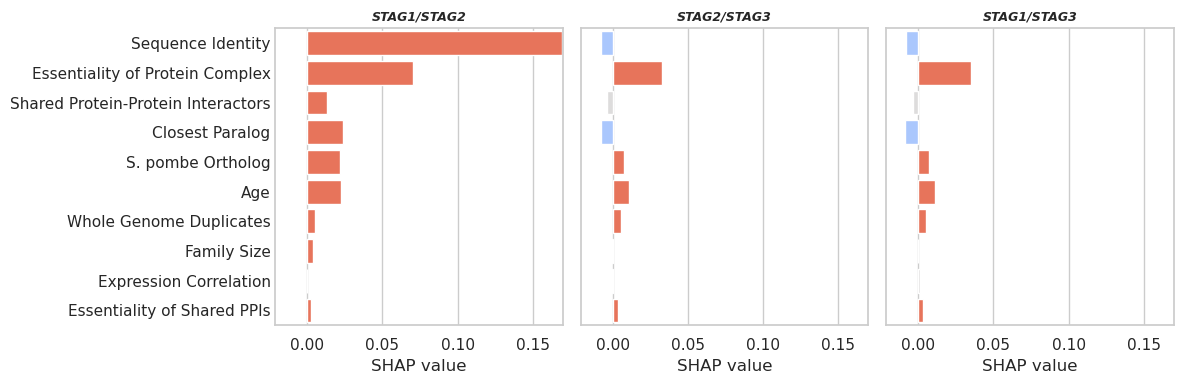

In [225]:


zmin=-2; zmax=2
palette = sns.color_palette("coolwarm", 5)
cmap = mpl.colors.ListedColormap(palette.as_hex())
f, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
draw_shap_plot_for_pair('STAG1', 'STAG2', ax[0], feature_order=top_features[:10])
draw_shap_plot_for_pair('STAG2', 'STAG3', ax[1], feature_order=top_features[:10])
draw_shap_plot_for_pair('STAG1', 'STAG3', ax[2], feature_order=top_features[:10])
ax[0].set_xlim([-0.021, 0.17])
plt.tight_layout()



### Summary

According to predictions pair STAG1 - STAG2 ranked on the 3rd place with the one of highest predicted score to be SL.

Wich goes in row with the https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7266993/ and https://www.biorxiv.org/content/biorxiv/early/2022/02/20/2022.02.18.479480.full.pdf

Features withe the highest contribution in case of STAG1/STAG2 are:

In [238]:
table_final = all_shap_and_zscore[all_shap_and_zscore["sorted_gene_pair"] == "STAG1_STAG2"].sort_values('shap_value',ascending=False).head(10)
table_final

sorted_gene_pair                       feature  zscore  shap_value  \
2           STAG1_STAG2         min_sequence_identity     2.0    0.169284   
623018      STAG1_STAG2     mean_complex_essentiality     2.0    0.070572   
36650       STAG1_STAG2                       closest     2.0    0.023557   
366482      STAG1_STAG2                      mean_age     2.0    0.022381   
183242      STAG1_STAG2            has_pombe_ortholog     2.0    0.021953   
219890      STAG1_STAG2  has_essential_pombe_ortholog     2.0    0.019101   
439778      STAG1_STAG2               fet_ppi_overlap     2.0    0.012984   
329834      STAG1_STAG2            conservation_score     2.0    0.006765   
109946      STAG1_STAG2              cds_length_ratio     2.0    0.006453   
146594      STAG1_STAG2                           WGD     2.0    0.005115   

        feature_value     A1     A2  prediction_rank  \
2               0.169  STAG1  STAG2                3   
623018          0.071  STAG1  STAG2                3   
36650           0.024  STAG1  STAG2                3   
366482          0.022  STAG1  STAG2                3   
183242          0.022  STAG1  STAG2                3   
219890          0.019  STAG1  STAG2                3   
439778          0.013  STAG1  STAG2                3   
329834          0.007  STAG1  STAG2                3   
109946          0.006  STAG1  STAG2                3   
146594          0.005  STAG1  STAG2                3   

                               simple_name  global_feat_rank  
2                        Sequence Identity                 0  
623018     Essentiality of Protein Complex                 1  
36650                      Closest Paralog                 3  
366482                                 Age                 5  
183242                   S. pombe Ortholog                 4  
219890         Essential S. pombe Ortholog                11  
439778  Shared Protein-Protein Interactors                 2  
329834                  Conservation Score                10  
109946                   Gene Length Ratio                12  
146594             Whole Genome Duplicates                 6

#### TOP10 features and data sources 

In [254]:
pd.options.display.max_colwidth = 500
pd.merge(table_final[["feature","zscore","shap_value"]],df_features, on="feature", how="left")[["feature","zscore","shap_value","description","source"]]

feature  zscore  shap_value  \
0         min_sequence_identity     2.0    0.169284   
1     mean_complex_essentiality     2.0    0.070572   
2                       closest     2.0    0.023557   
3                      mean_age     2.0    0.022381   
4            has_pombe_ortholog     2.0    0.021953   
5  has_essential_pombe_ortholog     2.0    0.019101   
6               fet_ppi_overlap     2.0    0.012984   
7            conservation_score     2.0    0.006765   
8              cds_length_ratio     2.0    0.006453   
9                           WGD     2.0    0.005115   

                                                                                                                                                                                                                                                                                                 description  \
0                                                                                                                                             The minimum of: the percent of A1's protein-coding sequence matched in A2 and vice versa. The percentages are different when A1 and A2 have different lengths.   
1  The mean essentiality of the complexes in which A1 and/or A2 form sub-units. Complex essentiality corresponds to the mean essentiality of the sub-units, excluding A1 and A2. Essentiality for each sub-unit is calculated as the percentage of cell lines in which it is essential (CERES score < -0.6).   
2                                                                                                                                                                                                                 Whether A1 and A2 are each other's closest paralog, as measured by min. sequence identity.   
3                                                                                                                                                                                                                                                                                 The mean age of A1 and A2.   
4                                                                                                                                                                                                                                                         Whether A1 and/or A2 have an ortholog in S. pombe.   
5                                                                                                                                                                                                                                               Whether A1 and/or A2 have an essential ortholog in S. pombe.   
6                                                                                                                   The -log10 p-value from the Fisher's exact test for the shared (vs. unshared) protein-protein interactors of A1 and A2. This captures how significantly A1 and A2's interactors overlap.   
7                                                                         Number of species, out of nine, in which A1 and/or A2 have an ortholog. The nine species considered are: A. thaliana, C. elegans, D. rerio, D. melanogaster, E. coli, M. musculus, R. norvegicus, S. cerevisiae and X. tropicalis.   
8                                                                                                                                                   The ratio of the lengths of A1 and A2's coding sequences (based on the longest transcript), calculated as shortest sequence divided by longest sequence.   
9                                                                                                                                                                                 Whether A1 and A2 originate from a whole genome duplication. False implies the pair stems from a scmall scale duplication.   

                              source  
0                            Ensem